In this report, we aim to determine the electric potential distribution inside a rectangular grid with grounded boundaries and a point charge at the center using three numerical methods: Jacobi, Gauss-Seidel, and Successive Over-Relaxation (SOR). These methods solve the discretized Poisson equation iteratively until convergence.
The Poisson equation for the electric potential V with a charge density ρ is given by:

$\Delta ^2 V=-\rho/\epsilon _0$

For a discrete grid, we get the update rule for the potential:
\
    Jacobi Method:
    The Jacobi method updates the potential at each grid point using the average of the potentials from the neighboring points from the previous iteration, adjusted for the charge density.  
    $$V_{i,j}=\frac{1}{4}(V_{i+1,j}+V_{i−1,j}+V_{i,j+1}+V_{i,j−1}+h^2\rho_{ij}/\epsilon _0)$$
    Gauss-Seidel Method:
    The Gauss-Seidel method updates the potential using the latest available values within the same iteration.
    $$V[i, j]^{n+1} = \frac{1}{4} \left( V[i+1, j]^n + V[i-1, j]^{n+1} + V[i, j+1]^n + V[i, j-1]^{n+1} +h^2\rho_{ij}/\epsilon _0 \right)$$
    Successive Over-Relaxation (SOR) Method:
    $$V[i, j]^{n+1} = (1-ω)V[i, j]+\frac{1}{4} \left( V[i+1, j]^n + V[i-1, j]^{n+1} + V[i, j+1]^n + V[i, j-1]^{n+1} +h^2\rho_{ij}\epsilon _0 \right)$$
$\epsilon _0$ is considered to be 1 for simplicity.

To find the electric potential for all points inside  a rectangle, the  side length of the sectangle was set to be $L_x$=$L_y$=1. Grid spacing is set to be $N_x$=$N_y$=21.
The opposite sides of the rectangle were assumed to be grounded, 0 V, for the short sides and 10 V for the long sides. For the charge in the center {-5,5,10} C values were chosen.

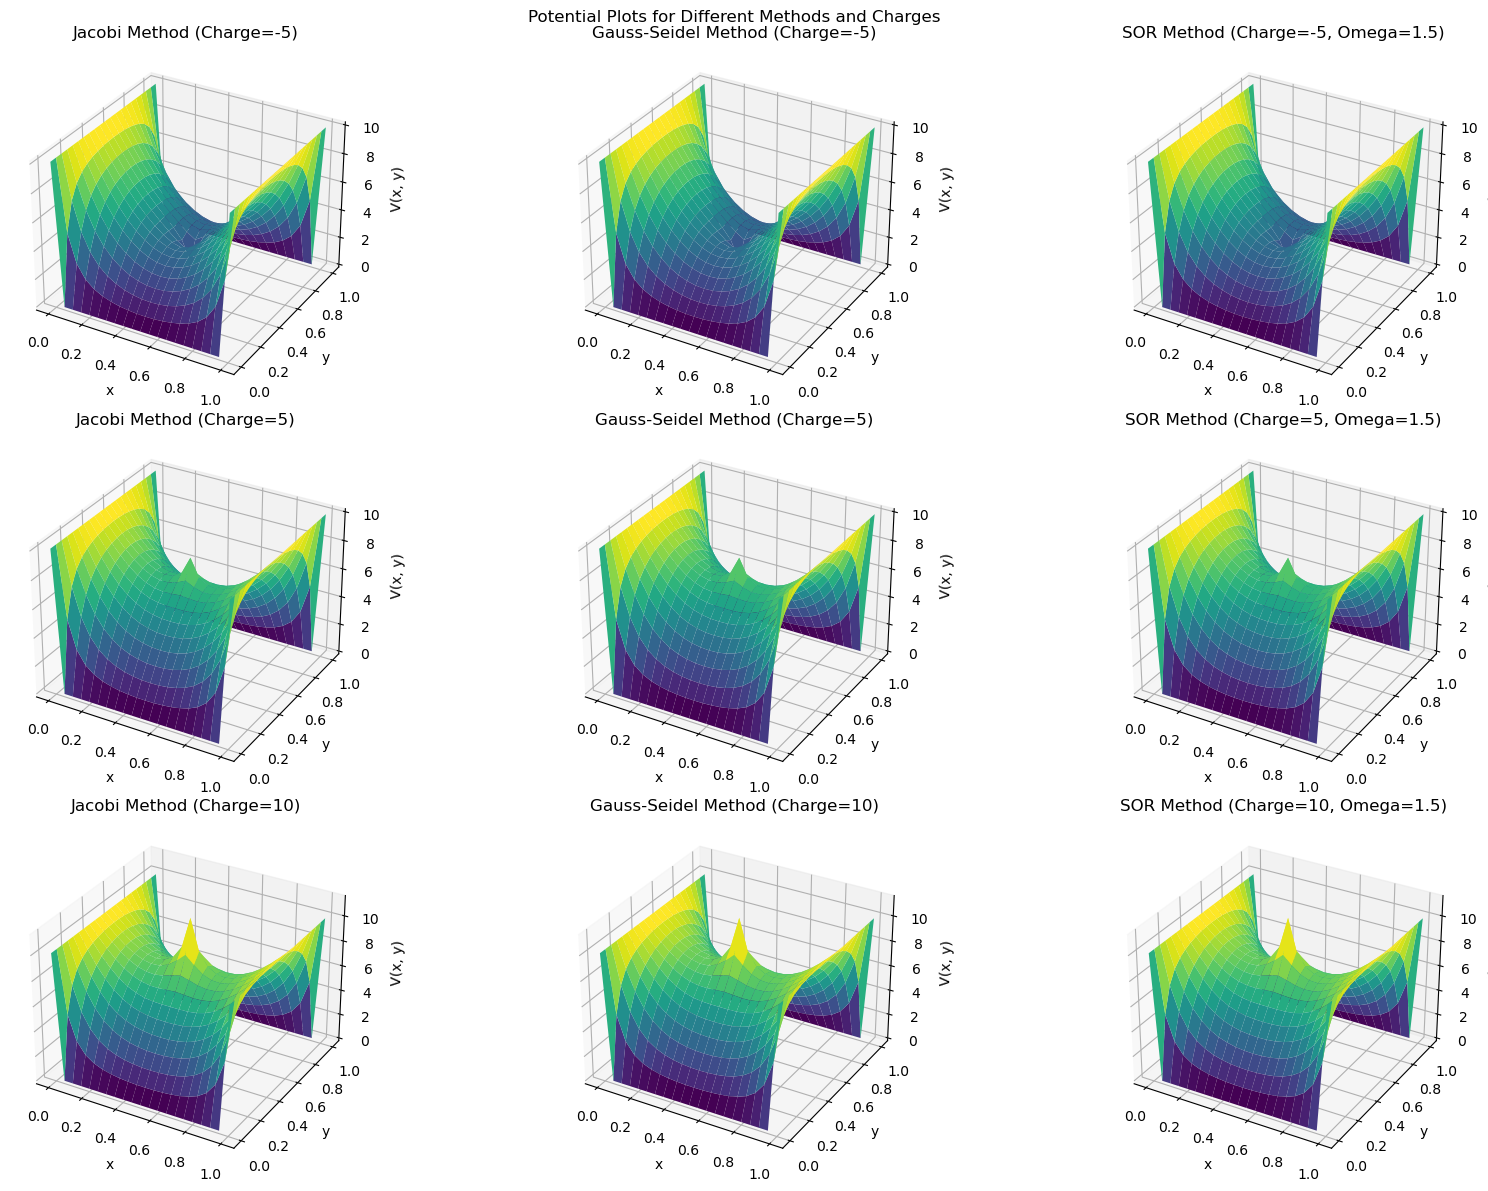

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters
Lx = 1.0 
Ly = 1.0  
Nx = 21 
Ny = 21  
hx = Lx/(Nx-1)  
hy = Ly/(Ny-1)  

rho=np.zeros((Nx, Ny))

# Initialize grid
V = np.zeros((Nx, Ny))

V[:, 0] = 0   
V[:, -1] = 0   
V[0, :] = 10   
V[-1, :] = 10 

# Charge in the middle
charge_position = (Nx // 2, Ny // 2)
charge_values = [-5, 5, 10]  # charge in C

# Function to plot the potential
def plot_potential(ax, V, title):
    x = np.linspace(0, Lx, Nx) 
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y)
    Z = V.T
    
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('V(x, y)')

# Jacobi method
def jacobi(V, charge_value, max_iterations=1000, tolerance=1e-4, charge_position = (21// 2, 21 // 2), rho=np.zeros((21, 21))):
    V_new= V.copy()
    
    Nx, Ny = np.shape(V)
    hx = Lx/(Nx-1)  
    hy = Ly/(Ny-1)

    rho[charge_position] = charge_value / (hx * hy)
      
    for iteration in range(max_iterations):
        V_old = V_new.copy()
        for i in range(1, Nx-1):
            for j in range(1, Ny-1):
                V_new[i, j] = 0.25 * (V_old[i+1, j] + V_old[i-1, j] + V_old[i, j+1] + V_old[i, j-1] + (hx * hy) * rho[i, j])
        
        if np.sum(np.abs(V_new - V_old)) < tolerance:
            break
    
    return V_new, iteration

# Gauss-Seidel method
def gauss_seidel(V, charge_value, max_iterations=1000, tolerance=1e-4, charge_position = (21 // 2, 21 // 2), rho=np.zeros((21, 21))):
    V_new = V.copy()
    Nx, Ny = np.shape(V)
    V_new[charge_position] = charge_value
    hx = Lx / (Nx - 1)  
    hy = Ly / (Ny - 1) 
    rho[charge_position] = charge_value / (hx * hy)

    for iteration in range(max_iterations):
        V_old = V_new.copy()
        for i in range(1, Nx-1):
            for j in range(1, Ny-1):
                V_new[i, j] = 0.25 * (V_old[i+1, j] + V_new[i-1, j] + V_old[i, j+1] + V_new[i, j-1] + (hx * hy) * rho[i, j])
        
        if np.sum(np.abs(V_new - V_old)) < tolerance:
            break
    
    return V_new, iteration

# Successive Over-Relaxation (SOR) method
def sor(V, charge_value, omega=1.5, max_iterations=1000, tolerance=1e-4, charge_position = (21 // 2, 21 // 2), rho=np.zeros((21, 21))):
    V_new = V.copy()
    
    Nx, Ny = np.shape(V)
    hx = Lx / (Nx - 1)  
    hy = Ly / (Ny - 1)
    V_new[charge_position] = charge_value
    rho[charge_position] = charge_value / (hx * hy)
    for iteration in range(max_iterations):
        V_old = V_new.copy()
        for i in range(1, Nx-1):
            for j in range(1, Ny-1):
                V_new[i, j] = (1 - omega) * V_old[i, j] + omega * 0.25 * (V_old[i+1, j] + V_new[i-1, j] + V_old[i, j+1] + V_new[i, j-1] + (hx * hy) * rho[i, j])
        
        if np.sum(np.abs(V_new - V_old)) < tolerance:
            break
    
    return V_new, iteration

# Function to print the number of iterations needed to converge
def print_convergence_iterations():
    print(f"{'Method':<20}{'Charge Value':<15}{'Iterations':<15}")
    print("-" * 50)
    
    for charge_value in charge_values:
        _, iter_jacobi = jacobi(V, charge_value)
        print(f"{'Jacobi':<20}{charge_value:<15}{iter_jacobi:<15}")
        
        _, iter_gauss_seidel = gauss_seidel(V, charge_value)
        print(f"{'Gauss-Seidel':<20}{charge_value:<15}{iter_gauss_seidel:<15}")
        
        _, iter_sor = sor(V, charge_value)
        print(f"{'SOR (Omega=1.5)':<20}{charge_value:<15}{iter_sor:<15}")

# Create subplots for each charge value and method
fig, axs = plt.subplots(3, 3, subplot_kw={'projection': '3d'}, figsize=(18, 12))
fig.suptitle('Potential Plots for Different Methods and Charges')

# Run and plot for different charge values
for i, charge_value in enumerate(charge_values):
    V_jacobi, _ = jacobi(V, charge_value)
    plot_potential(axs[i, 0], V_jacobi, f'Jacobi Method (Charge={charge_value})')
    
    V_gauss_seidel, _ = gauss_seidel(V, charge_value)
    plot_potential(axs[i, 1], V_gauss_seidel, f'Gauss-Seidel Method (Charge={charge_value})')
    
    V_sor, _ = sor(V, charge_value)
    plot_potential(axs[i, 2], V_sor, f'SOR Method (Charge={charge_value}, Omega=1.5)')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

# Function to investigate the effect of varying grid spacing
def investigate_grid_spacing():
    hs = np.linspace(0.01, 1.0, 20)  # Grid step sizes
    jacobi_iterations = []
    gauss_seidel_iterations = []
    sor_iterations = []
    
    for h in hs:
        Nx = int(Lx / h) + 1
        Ny = int(Ly / h) + 1
        V = np.zeros((Nx, Ny))
        V[:, 0] = 0
        V[:, -1] = 0
        V[0, :] = 10
        V[-1, :] = 10
        rho = np.zeros((Nx, Ny))
        charge_position = (Nx // 2, Ny // 2)
        
        _, iter_jacobi = jacobi(V, 5, charge_position=charge_position, rho=rho)
        jacobi_iterations.append(iter_jacobi)
        
        _, iter_gauss_seidel = gauss_seidel(V, 5, charge_position=charge_position, rho=rho)
        gauss_seidel_iterations.append(iter_gauss_seidel)
        
        _, iter_sor = sor(V, 5, omega=1.5, charge_position=charge_position, rho=rho)
        sor_iterations.append(iter_sor)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(hs, jacobi_iterations, label='Jacobi Method')
    plt.plot(hs, gauss_seidel_iterations, label='Gauss-Seidel Method')
    plt.plot(hs, sor_iterations, label='SOR Method')
    
    plt.xlabel('Grid Step Size (h)')
    plt.ylabel('Iterations to Converge')
    plt.title('Iterations to Converge with Tolerance $10^{-4}$ over Grid Step Size')
    plt.legend()
    plt.grid(True)
    plt.show()


The plots above represent electric potential V inside the box for three different charge values: -5, 5 and 10 C. For -5 C it is visible that potential has hollow, so it means that potential dropps down, which is caused from the negative value  of the charge. For 5 and 10 C small and bigger peaks are constructed respectively. Which is again logical result since both of the charges have positivie values. All the algorithm methods: Jacobi, Gauss siedel and SOR  performed similar results. 

After that itterations needed for each method to converge  with precision such as 10^-4 was investigated. For this purpose print_convergence_iterations() was written, which prints itteration numbers for each method and each charge. See below:

In [3]:
print_convergence_iterations()



Method              Charge Value   Iterations     
--------------------------------------------------
Jacobi              -5             957            
Gauss-Seidel        -5             508            
SOR (Omega=1.5)     -5             177            
Jacobi              5              978            
Gauss-Seidel        5              517            
SOR (Omega=1.5)     5              180            
Jacobi              10             986            
Gauss-Seidel        10             521            
SOR (Omega=1.5)     10             181            


For a charge value of -5, the Jacobi method required 957 iterations, the Gauss-Seidel method required 508 iterations, and the SOR method with $\omega = 1.5$ required only 177 iterations. With a charge value of 5, the Jacobi method took 978 iterations, Gauss-Seidel took 517, and SOR took 180 iterations. For a charge value of 10, Jacobi needed 986 iterations, Gauss-Seidel needed 521, and SOR needed 181 iterations.

The data clearly shows that the SOR method consistently requires the fewest iterations to converge, followed by the Gauss-Seidel method, with the Jacobi method needing the most iterations for all charge values tested. This demonstrates the efficiency of the SOR method in achieving faster convergence.

The Table above confirms once again that Jacobi method needs much more itterations compared to the Gauss Seidel and SOR iterations. SOR method needs the least amount of iterrations.

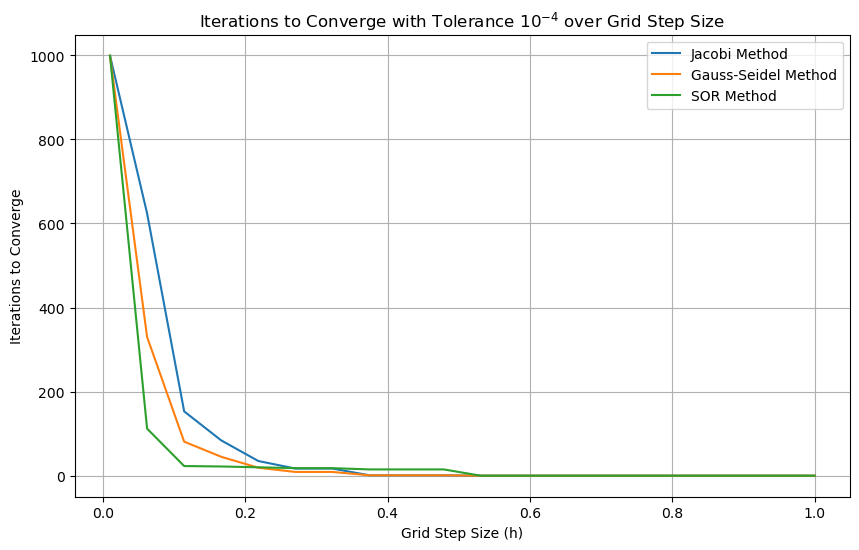

In [5]:
investigate_grid_spacing()

After that how the grid step size h affects the convergence of Jacobi, Gauss-Seidel, and Successive Over-Relaxation (SOR) methods was investigated. The graph shows that as h decreases, the number of iterations increases significantly for all methods, indicating higher computational effort for finer grids. The Jacobi method needs the most iterations, followed by Gauss-Seidel, with the SOR method which converges the fastest.

Smaller h values improve accuracy but increase computational cost, while larger h values are more efficient but less accurate. The SOR method is the most efficient and stable, requiring fewer iterations across all grid sizes.